# Normalize Chromatin and Naked data for ATAC comparison
### Hagai Har-Gil

After some exploration done in the `explore` notebook, this one should be a more succint version of the actual pipeline we wish to preserve.

In [63]:
%load_ext autoreload
%autoreload 2
%load_ext nb_black
import pathlib
import copy
from typing import Tuple, List

import seaborn as sns
import numpy as np
import pandas as pd
import skimage.exposure
import matplotlib.pyplot as plt
import scipy.signal
import scipy.fftpack

from ecodam_py.bedgraph import BedGraphAccessor, BedGraphFile
from ecodam_py.eco_atac_normalization import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>

In [3]:
eco_fname = pathlib.Path(
    "/mnt/saphyr/Saphyr_Data/DAM_DLE_VHL_DLE/Hagai/original_data/chromatin_chr15.filter17_60_75.NoBlacklist.NoMask.bedgraph"
)
atac_fname = pathlib.Path(
    "/mnt/saphyr/Saphyr_Data/DAM_DLE_VHL_DLE/Hagai/original_data/ATAC_rep1to3_Fold_change_over_control.chr15.bedgraph"
)
naked_fname = pathlib.Path(
    "/mnt/saphyr/Saphyr_Data/DAM_DLE_VHL_DLE/Hagai/original_data/NakedAF647_channel2_chr15_NoMissingChromatinWin.BEDgraph"
)
theo_fname = pathlib.Path(
    "/mnt/saphyr/Saphyr_Data/DAM_DLE_VHL_DLE/Hagai/original_data/hg38.1kb.windows.InSilico.count.map.sum.bedgraph"
)

In [4]:
beds = preprocess_bedgraph([eco_fname, atac_fname, naked_fname])
beds[1].data.loc[:, "end_locus"] += 100  # ATAC data is built a bit differently

### Theoretical data pre-processing

In parallel we prepare the theoretical data - turn it into an object and reindex it so that it refers to the exact same loci as the naked data, which serves as its reference point. 

There's some averaging going on here, since currently the theoretical data is sampled at (1000, 2000, 3000, ...) bp while the rest of the data is sampled at (500, 1500, 2500, ...) bp. This means that if we want the theoretical data to point at the exact same loci as the naked one, we have to average out every two theoretical values (at least) to find their middle point, which will serve as the new index for the data. This bit will run in `reindex_theo_data`, which is called after the next cell.

In [5]:
theo = preprocess_theo(theo_fname)

### Coercion to the same loci

Next up, we need to do a bit of manipulation to make sure that all values for the different measurements are defined for the exact same loci. The theoretical data will get special treatment later.

The function `put_on_even_grounds` makes sure that the datasets start and end in the same locus, and the `generate_intervals_1kb` function is called on the ATAC data to smooth it out and finally "reindex" it so that it refers to the same loci as the rest of the data. The index here is the locus values at which the measurement was made. Finally, the function `reindex_data_with_known_intervals` does the work of actually changing the indices of the datasets which aren't Eco with chromatin.

In [6]:
beds = put_on_even_grounds(beds)
beds = convert_to_intervalindex(beds)
newint = generate_intervals_1kb(beds[1].data)
eco = beds[0]
atac = beds[1]
naked = beds[2]
atac.data, naked.data, theo.data = reindex_data_with_known_intervals(
    newint, atac, naked, theo, eco.data.index
)
theo.data = reindex_theo_data(naked.data, theo.data)

### Normalization of Naked and Chromatin by ATAC peaks

The idea now is to use the open areas of the chromosome, as defined by ATAC, to normalize the other areas of the chromatin track, or simply to see if there's any difference in their distributions. 

Sadly we can't simply look at the NFR as defined by ATAC and use them to find the "open" chromatin regions. This is understod by looking at the IGV traces - we see that these NFR can be very narrow, but the chromatin's low resolution means that a small open area leads to an entire KB being "grabbed" and tagged as an NFR. The result is that if we do this naively, we tag as open about 2/3 of the genome. To circumvent this we'll only use longer open regions, i.e. areas where the number of open BP is the majority of BP. The logic described above is coded in `get_index_values_for_nfr()`.

In [61]:
nfr_atac = pd.read_csv(
    "/mnt/saphyr/Saphyr_Data/DAM_DLE_VHL_DLE/Hagai/ENCFF240YRV_top_peaks.bedgraph",
    sep="\t",
    names=["chr", "start_locus", "end_locus", "intensity"],
)
chrom = eco.data.copy()
chrom.loc[:, 'start_locus'] = chrom.index.left
chrom.loc[:, 'end_locus'] = chrom.index.right
chrom = chrom.reset_index().drop('locus', axis=1)
nfr_loci = get_index_values_for_nfr(nfr_atac, chrom)

There's some post-processing that has to be done on the results so that they'd be usable later on in this script:

In [8]:
nfr_indices = nfr_loci.index.to_numpy()
nfr_loci.loc[:, "locus"] = pd.IntervalIndex.from_arrays(
    nfr_loci.loc[:, "start_locus"], 
    nfr_loci.loc[:, "end_locus"], 
    closed="left", 
    name="locus"
)
nfr_loci = nfr_loci.set_index("locus").drop(['start_locus', 'end_locus'], axis=1)

/home/hagaih/miniconda3/envs/ecodam/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/hagaih/miniconda3/envs/ecodam/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [9]:
nfr_atac.loc[:, "locus"] = pd.IntervalIndex.from_arrays(
    nfr_atac.loc[:, "start_locus"],
    nfr_atac.loc[:, "end_locus"],
    closed="left",
    name="locus",
)
nfr_atac = nfr_atac.set_index("locus").drop(["start_locus", "end_locus"], axis=1)

In [10]:
non_nfr_loci = eco.data.loc[eco.data.index.difference(nfr_loci.index)]
non_nfr_indices = np.setdiff1d(np.arange(len(chrom)), nfr_indices)
assert len(non_nfr_loci) == len(non_nfr_indices)

Let's first observe how does the Naked and Chromatin peak data looks like - i.e. the values of one of these tracks at the HMMRATAC-defined indices.

<AxesSubplot:xlabel='Chromatin', ylabel='Naked'>

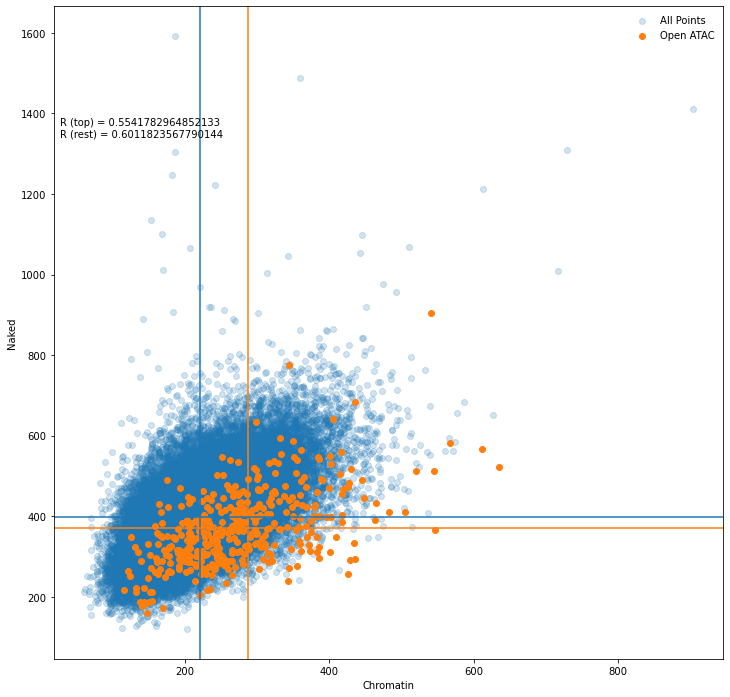

In [11]:
top_chrom, top_naked, non_top_chrom, non_top_naked = separate_top_intensity_values(
    eco.data, naked.data, nfr_indices, non_nfr_indices
)
scatter_peaks_no_peaks(top_chrom, top_naked, non_top_chrom, non_top_naked)

The differences are noticeable, but not too big - the peak-based Chromatin data is higher than the rest of the data. This is, again, a testament to the low SNR we're working with.

Before moving on, let's look at the data in one more way:

In [12]:
all_chrom = pd.concat([non_top_chrom, top_chrom], keys=["all", "top"])
all_naked = pd.concat([non_top_naked, top_naked], keys=["all", "top"])
chrom_and_naked = pd.concat([all_chrom, all_naked], keys=["chrom", "naked"])
chrom_and_naked.index.rename(["source", "measurement", "locus"], inplace=True)

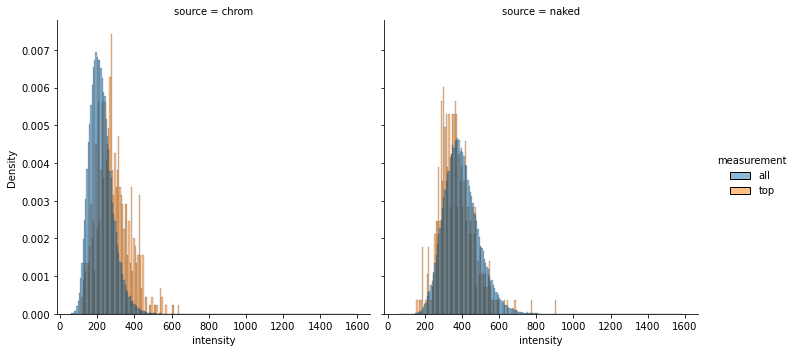

In [13]:
sns.displot(
    data=chrom_and_naked.to_frame(),
    x="intensity",
    hue="measurement",
    common_norm=False,
    stat="density",
    col="source",
)

## Comparison with DNase

We need to see whether the data matches the DNase distribution as well.

We'll take the DNase peaks and see if they correspond to higher chromatin values.

In [14]:
import pybedtools

dnase = pybedtools.BedTool(
    "/mnt/saphyr/Saphyr_Data/DAM_DLE_VHL_DLE/Michael/R/Refrences/Wu_merged_hotspots_as_windows.sort.bed"
)

dnase_chr15 = (
    dnase.to_dataframe()
    .query('chrom == "chr15"')
    .rename({"chrom": "chr", "start": "start_locus", "end": "end_locus"}, axis=1)
    .reset_index(drop=True)
)

In [15]:
peaks_from_dnase = get_peak_indices(dnase_chr15,  eco.data)
non_peaks_dnase = np.setdiff1d(np.arange(len(eco.data)), peaks_from_dnase)
top_chrom, top_naked, non_top_chrom, non_top_naked = separate_top_intensity_values(
    eco.data, naked.data, peaks_from_dnase, non_peaks_dnase
)

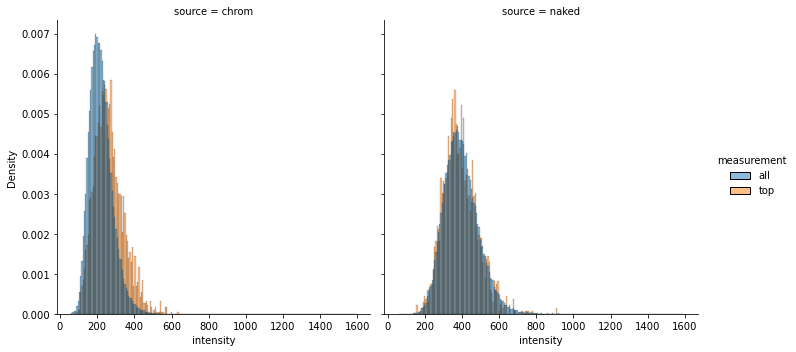

In [16]:
all_chrom = pd.concat([non_top_chrom, top_chrom], keys=["all", "top"])
all_naked = pd.concat([non_top_naked, top_naked], keys=["all", "top"])
chrom_and_naked = pd.concat([all_chrom, all_naked], keys=["chrom", "naked"])
chrom_and_naked.index.rename(["source", "measurement", "locus"], inplace=True)
sns.displot(
    data=chrom_and_naked.to_frame(),
    x="intensity",
    hue="measurement",
    common_norm=False,
    stat="density",
    col="source",
)

## Group-wise comparisons

We'll divide the whole chromosome into groups - each time we'll only take 100 (or so) peaks, bundle them together and do the normalization and analysis steps inside that group.

In [17]:
# Divide the peaks into groups
groupnum = 8  # nearly even groups
segments = np.linspace(
    0, len(nfr_indices), num=groupnum, dtype=np.int64, endpoint=True
)[1:-1]
# Define the limits of each group using peak index
peak_segments = nfr_indices[segments]
peak_groups = np.split(nfr_indices, segments)
# Split up data at these intervals
naked_groups = np.split(naked.data.loc[:, "intensity"], peak_segments)
chrom_groups = np.split(eco.data.loc[:, "intensity"], peak_segments)
theo_groups = np.split(theo.data.loc[:, "intensity"], peak_segments)
print(f"Generated {len(segments)} groups!")
# Change peak indices to relative per group
peak_segments = np.concatenate([[0], peak_segments])
peak_groups_relative = [
    group - starting for group, starting in zip(peak_groups, peak_segments)
]
peak_segments = np.concatenate([peak_segments, [len(naked.data)]])

Generated 6 groups!


We'll also divide the non-peak indices into the same groups - they just need a different treatment:

In [18]:
non_nfr_groups = []
non_nfr_groups_relative = []
for idx, start in enumerate(peak_segments[:-1]):
    end = peak_segments[idx + 1]
    mask = (non_nfr_indices >= start) & (non_nfr_indices < end)
    non_nfr_groups.append(non_nfr_indices[mask])
    non_nfr_groups_relative.append(non_nfr_indices[mask] - start)

For each of these groups we wish to draw the same scatterplot as we did before for the entire chromosome, since it might be of interest to find areas that are more or less affected by the peaks.

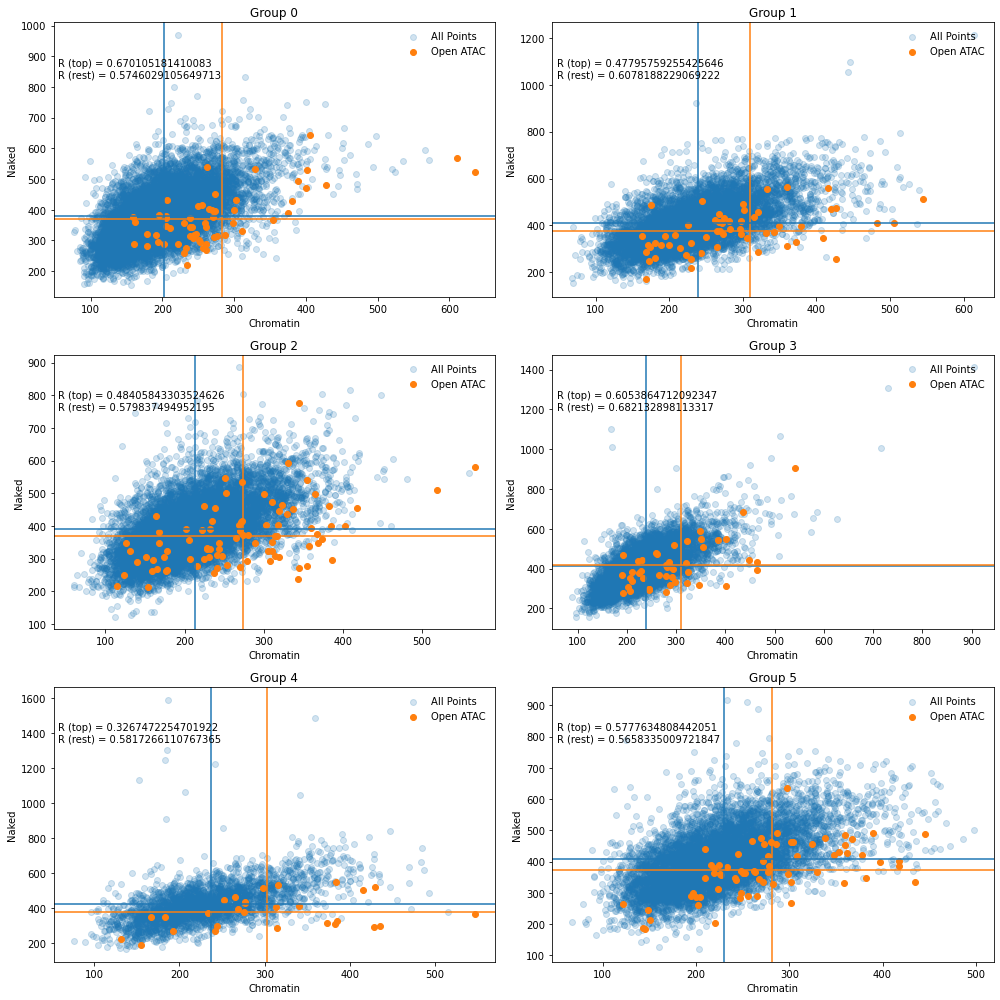

In [19]:
fig_groups, ax_groups = plt.subplots(3, 2, figsize=(14, 14))
for idx, (ax_grp, peaks, non_peaks, chrom, nak) in enumerate(
    zip(
        ax_groups.flat,
        peak_groups_relative,
        non_nfr_groups_relative,
        chrom_groups,
        naked_groups,
    )
):
    ax = scatter_peaks_no_peaks(
        chrom.iloc[peaks],
        nak.iloc[peaks],
        chrom.iloc[non_peaks],
        nak.iloc[non_peaks],
        ax_grp,
    )
    ax.set_title(f"Group {idx}")
ax.figure.tight_layout()

The main takeaways are that the chromatin data seems to be more sensitive to the peaks than the naked data. This is expected since the naked data is always open. We also see that some groups have relatively lower Chromatin SNR than other, or in other words the data in these groups doesn't reflect well the openness of the chromosome as the ATAC data suggests.

Now let's go over group-by-group and normalize the peaks between the chromatin and naked data. This normalization step is composed of two steps:

1. Match the peak heights of the naked and chromatin data. This step makes sure that the group's peaks are more-or-less identical in their average height. This is important if we wish to subtract the two tracks.
2. Remove the background noise from the tracks. The background levels of the two tracks a bit different, which might hurt the subtraction step.

After normalization we'll take two actions:

1. Generate a subtraction group after these previously-described steps.
2. Normlize the chromatin data from the naked, by equalizing the naked data's height and then applying that same filter to the chromatin data.

Regardless of the action used, we'll remove areas with low theoretical values since they're less credible. 

In [20]:
chrom_norm_groups, naked_norm_groups, chrom_normed_by_naked_groups = [], [], []
subtraction = pd.DataFrame(columns=["intensity"], index=eco.data.index)
for idx, (
    peaks,
    nakedgroup,
    chromgroup,
    non_nfr_chrom,
    theogroup,
) in enumerate(
    zip(
        peak_groups_relative,
        naked_groups,
        chrom_groups,
        non_nfr_groups_relative,
        theo_groups,
    )
):
    naked_norm, norm = normalize_group_peaks_single_factor(peaks, nakedgroup)
    chrom_norm, _ = normalize_group_peaks_single_factor(peaks, chromgroup, norm_to=norm)
    no_sites = theogroup == 0
    naked_norm = subtract_background_with_theo(naked_norm, no_sites)
    chrom_norm = subtract_background_with_theo(chrom_norm, no_sites)    
    subtraction.loc[chrom_norm.index, "intensity"] = naked_norm - chrom_norm
    chrom_norm_groups.append(chrom_norm.dropna())
    naked_norm_groups.append(naked_norm.dropna())
subtraction = subtraction.dropna()
chrom_norm_all = pd.concat(chrom_norm_groups)
naked_norm_all = pd.concat(naked_norm_groups)

In [21]:
new_foldername = eco_fname.parent / "data_after_group_norm"
new_foldername.mkdir(exist_ok=True)
write_intindex_to_disk(
    chrom_norm_all,
    new_foldername
    / "chromatin_chr15.filter17_60_75.NoBlacklist.NoMask_after_group_normalization.bedgraph",
)
write_intindex_to_disk(
    naked_norm_all,
    new_foldername
    / "NakedAF647_channel2_chr15_NoMissingChromatinWin_after_group_normalization.bedgraph",
)
write_intindex_to_disk(subtraction, new_foldername / "naked_minus_chromatin.bedgraph")

Since we have these normalized distributions, we can look at the same types of plots but using this new data. 

<AxesSubplot:xlabel='Chromatin', ylabel='Naked'>

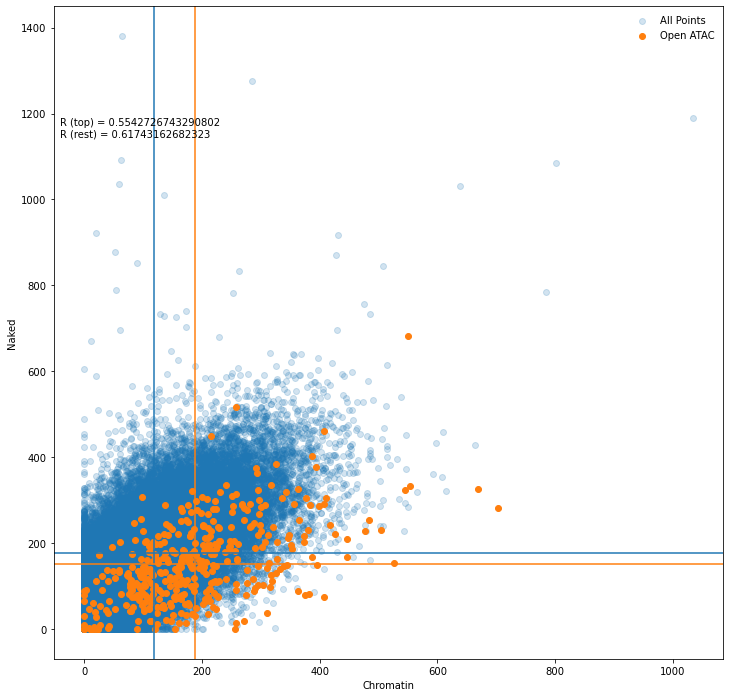

In [22]:
top_chrom_norm = chrom_norm_all.reindex(nfr_loci.index).dropna()
top_naked_norm = naked_norm_all.reindex(nfr_loci.index).dropna()
non_top_chrom_norm = chrom_norm_all.reindex(non_nfr_loci.index).dropna()
non_top_naked_norm = naked_norm_all.reindex(non_nfr_loci.index).dropna()

scatter_peaks_no_peaks(top_chrom_norm.loc[top_naked_norm.index], top_naked_norm, non_top_chrom_norm.loc[non_top_naked_norm.index], non_top_naked_norm)

We'll plot the correlation between the theoretical data and the other datasets we currently have - subtracted track and the chromatin and naked tracks. Then we'll correct for the theoretical data and see how it looks like again.

In [23]:
theo_no_zero = theo.data.dropna()
theo_no_zero = theo_no_zero.loc[theo_no_zero.intensity != 0, "intensity"].to_frame().reindex(subtraction.index)
theo_no_zero.loc[:, "subtraction"] = subtraction.intensity
theo_no_zero.loc[:, "chromatin"] = chrom_norm_all
theo_no_zero.loc[:, "naked"] = naked_norm_all
theo_no_zero = theo_no_zero.rename({"intensity": "theo_value"}, axis=1)

<AxesSubplot:xlabel='theo_value', ylabel='intensity'>

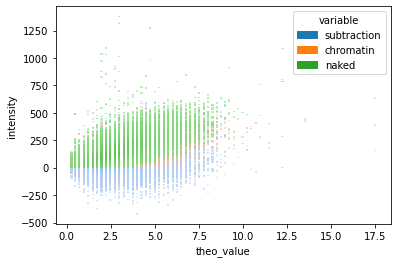

In [24]:
sns.histplot(
    data=theo_no_zero.melt(
        id_vars=["theo_value"],
        value_name="intensity",
    ).astype({"intensity": np.float64}),
    x="theo_value",
    y="intensity",
    hue="variable",
    alpha=0.5,
    linewidth=10,
)

In [25]:
open_by_quant, closed_by_quant = classify_open_closed_loci_with_quant(subtraction)
intersection = []
for nfr in nfr_loci.index:
    overlap = np.where(open_by_quant.index.overlaps(nfr))[0]
    if overlap.size > 0:
        intersection.append(overlap)
nfr_subtraction_intersection = np.asarray(intersection).ravel()
closed_nfr_subtraction = np.setdiff1d(np.arange(len(open_by_quant)), nfr_subtraction_intersection)
len(nfr_subtraction_intersection) / len(closed_nfr_subtraction)

0.0074613608100906025

In [26]:
open_by_dnase = eco.data.iloc[peaks_from_dnase].drop('chr', axis=1)
intersection = []
for dnase in open_by_dnase.index:
    overlap = np.where(open_by_quant.index.overlaps(dnase))[0]
    if overlap.size > 0:
        intersection.append(overlap)
dnase_subtraction_intersection = np.asarray(intersection).ravel()
closed_dnase_subtraction = np.setdiff1d(np.arange(len(open_by_quant)), dnase_subtraction_intersection)
len(dnase_subtraction_intersection) / len(closed_dnase_subtraction)

0.03929093567251462

We'll normalize the subtraction using the theoretical value:

In [27]:
subtraction.loc[:, "intensity"] = normalize_with_theo(subtraction.intensity, theo.data)
chrom_norm_theo = normalize_with_theo(chrom_norm_all, theo.data)
naked_norm_theo = normalize_with_theo(naked_norm_all, theo.data)

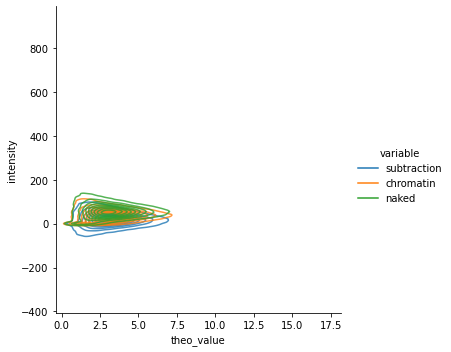

In [28]:
theo_no_zero_normed = theo_no_zero.copy()
theo_no_zero_normed.loc[:, "subtraction"] = subtraction.intensity
theo_no_zero_normed.loc[:, "chromatin"] = chrom_norm_theo
theo_no_zero_normed.loc[:, "naked"] = naked_norm_theo
sns.displot(
    data=theo_no_zero_normed.melt(
        id_vars=["theo_value"],
        value_name="intensity",
    ).astype({"intensity": np.float64}),
    x="theo_value",
    y="intensity",
    hue="variable",
    alpha=0.8,
    kind="kde",
)

In [29]:
new_foldername = eco_fname.parent / "data_after_theo_norm"
new_foldername.mkdir(exist_ok=True)
write_intindex_to_disk(
    chrom_norm_all,
    new_foldername
    / "chromatin_chr15.filter17_60_75.NoBlacklist.NoMask_after_theo_normalization.bedgraph",
)
write_intindex_to_disk(
    naked_norm_all,
    new_foldername
    / "NakedAF647_channel2_chr15_NoMissingChromatinWin_after_theo_normalization.bedgraph",
)
write_intindex_to_disk(
    subtraction, new_foldername / "naked_minus_chromatin_after_theo_norm.bedgraph"
)

Now we'll try to look only at loci that contained a Naked-Theo wavelet correlation value higher than 0.5:

In [30]:
high_corr_fname = pathlib.Path(
    "/mnt/saphyr/Saphyr_Data/DAM_DLE_VHL_DLE/Correlations_chr15_for_histograms/Correlations_for_$4_histograms/Naked_Theoretical.0.5Up_smoothed_1kb_coerced_to_ATAC_rep1to3_Fold_change_over_control.chr15_after_normalization.bedgraph"
)
high_corr = BedGraphFile(high_corr_fname, header=False)
high_corr.data = high_corr.data.query("intensity > 0")

In [31]:
high_corrs = convert_to_intervalindex([high_corr])
high_corr = high_corrs[0]

In [32]:
high_corr.data

,chr,intensity
locus,,
"[22632500, 22633500)",chr15,0.519813
"[22633500, 22634500)",chr15,0.381740
"[22634500, 22635500)",chr15,0.127250
"[22635500, 22636500)",chr15,0.157580
"[22636500, 22637500)",chr15,0.282482
...,...,...
"[101709500, 101710500)",chr15,0.700478
"[101710500, 101711500)",chr15,0.105629
"[101713500, 101714500)",chr15,0.117736


In [33]:
merged = theo_no_zero.merge(high_corr.data, how="inner", on="locus")
merged

,theo_value,subtraction,chromatin,naked,chr,intensity
locus,,,,,,
"[22632500, 22633500)",2.00,29.3827,127.713343,157.096073,chr15,0.519813
"[22633500, 22634500)",2.75,42.7128,133.663341,176.376163,chr15,0.381740
"[22634500, 22635500)",2.25,31.2296,183.523291,214.752903,chr15,0.127250
"[22635500, 22636500)",2.50,13.7382,162.449607,176.187803,chr15,0.157580
"[22636500, 22637500)",4.50,-7.25785,212.209387,204.951533,chr15,0.282482
...,...,...,...,...,...,...
"[101702500, 101703500)",3.00,26.4871,134.003805,160.490895,chr15,0.027342
"[101708500, 101709500)",1.25,-10.8847,10.884680,0.000000,chr15,0.165394
"[101709500, 101710500)",1.00,-6.94442,6.944421,0.000000,chr15,0.700478


In [34]:
merged = theo_no_zero.merge(high_corr.data, how="inner", on="locus").drop(
    ["subtraction", "chr", "intensity"], axis=1
)
merged = merged.melt(
    id_vars=["theo_value"],
    value_name="intensity",
).astype({"intensity": np.float64})
merged

,theo_value,variable,intensity
0,2.00,chromatin,127.713343
1,2.75,chromatin,133.663341
2,2.25,chromatin,183.523291
3,2.50,chromatin,162.449607
4,4.50,chromatin,212.209387
...,...,...,...
77025,3.00,naked,160.490895
77026,1.25,naked,0.000000
77027,1.00,naked,0.000000
77028,3.50,naked,126.173025


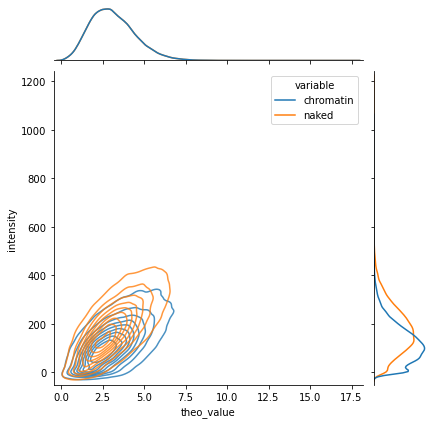

In [35]:
sns.jointplot(
    data=merged,
    x="theo_value",
    y="intensity",
    hue="variable",
    alpha=0.8,
    kind="kde",
)

Our next goal is to classify the lower 10% of the subtration track as open, and see if it helps.

## Very closed NFR

We'll try to look for closed NFRs - i.e. areas that don't contain NFRs at all, and see whether the chromatin data sees it.

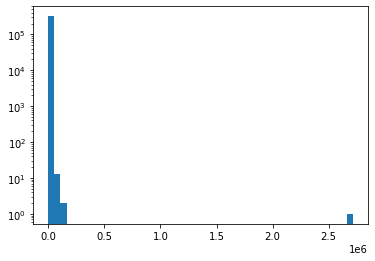

<IPython.core.display.Javascript object>

In [82]:
nfr_atac = nfr_atac.bg.columns_to_index()
ends = nfr_atac.index.right[:-1]
starts = nfr_atac.index.left[1:]
diffs = starts - ends
fig, ax = plt.subplots()
ax.hist(diffs, bins=50)
ax.set_yscale("log")

There's an outlier, but we can also see some sort of distribution. Let's use quantiles to find these areas.

In [83]:
quantile = np.quantile(diffs.to_numpy(), q=0.99)
print(f"The value of quantiles in BP is {quantile}")
quantmask = diffs > quantile
ends = ends[quantmask]
starts = starts[quantmask]
non_nfr = pd.DataFrame(
    {"chr": "chr15", "start_locus": ends, "end_locus": starts, "intensity": 1}
)
non_nfr

The value of quantiles in BP is 3637.3099999999977


,chr,start_locus,end_locus,intensity
0,chr15,17013842,17029633,1
1,chr15,17029701,17037583,1
2,chr15,17037677,17080729,1
3,chr15,17083303,19796751,1
4,chr15,19796824,19876957,1
...,...,...,...,...
3184,chr15,101858943,101912533,1
3185,chr15,101913027,101918405,1
3186,chr15,101918475,101922401,1
3187,chr15,101924590,101928314,1


<IPython.core.display.Javascript object>

Now we find the areas in the chromatin dataset that correspond to these very closed areas and see how well do they differentiate from the non so closed areas.

In [86]:
chrom = chrom.to_frame().assign(chr="chr15").index_to_columns()
closed_area_rows = get_index_values_for_nfr(non_nfr, chrom, open_pct=0.85)
open_area_indices = np.setdiff1d(np.arange(len(chrom)), closed_area_indices)

<IPython.core.display.Javascript object>

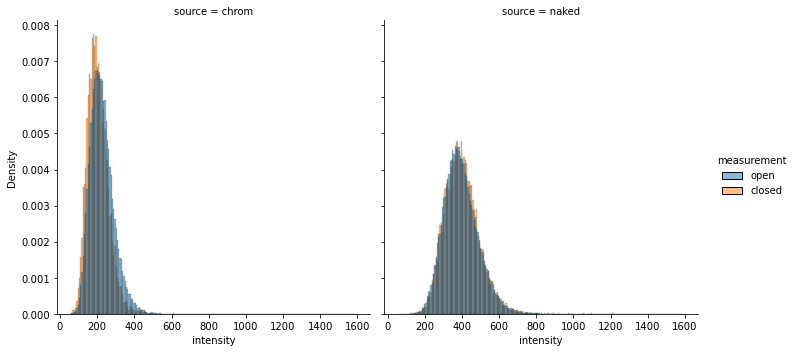

<IPython.core.display.Javascript object>

In [87]:
closed_chrom, closed_naked, open_chrom, open_naked = separate_top_intensity_values(
    eco.data, naked.data, closed_area_indices, open_area_indices
)
all_chrom = pd.concat([open_chrom, closed_chrom], keys=["open", "closed"])
all_naked = pd.concat([open_naked, closed_naked], keys=["open", "closed"])
chrom_and_naked = pd.concat([all_chrom, all_naked], keys=["chrom", "naked"])
chrom_and_naked.index.rename(["source", "measurement", "locus"], inplace=True)
sns.displot(
    data=chrom_and_naked.to_frame(),
    x="intensity",
    hue="measurement",
    common_norm=False,
    stat="density",
    col="source",
)

As expected, there's not too much to see here - the closed areas seem just a tiny bit less bright than the closed ones.

## High Coverage Areas Analysis

The next step we wish to take is to look on areas in the genome where both the naked and the chromatin tracks had a high coverage percentage - the top 10% in this case. When we intersect these two areas we're supposed to receive an area with a higher data quality.

In [88]:
highcov_chrom_fname = pathlib.Path(
    "/mnt/saphyr/Saphyr_Data/DAM_DLE_VHL_DLE/Michael/Chromatin_rep1/filtered_xmap/Filtered_by_occourence/Chromatin_chr15 filtered_results_occ1_220.NolackMask.BEDgraph"
)
highcov_naked_fname = pathlib.Path(
    "/mnt/saphyr/Saphyr_Data/DAM_DLE_VHL_DLE/Michael/Chromatin_rep1/filtered_xmap/Filtered_by_occourence/Naked_chr15_filtered_results_occ1_157.NoBlackMask.BEDgraph"
)

<IPython.core.display.Javascript object>